# Nomes

- André Monteiro Sanches Garcia -19.01230-6
- Arthur C Sarnadas – 19.00756-6
- Giovanni B Benuthe – 19.00043-0
- Guilherme Bernardelli Zeigler - 19.02453-3

## Reconhecimento de imagens de frutas e se estão ou não podres
Existem 6 categorias de fruta: maça fresca, laranja fresca, banana fresca, maca podre, laranja podre e banana podre.Isso significa que nossa camada de saida receberá 6 neuronios. Será necessário compilar o modelo com categorical_crossentropy, ja que temos mais de duas categorias.

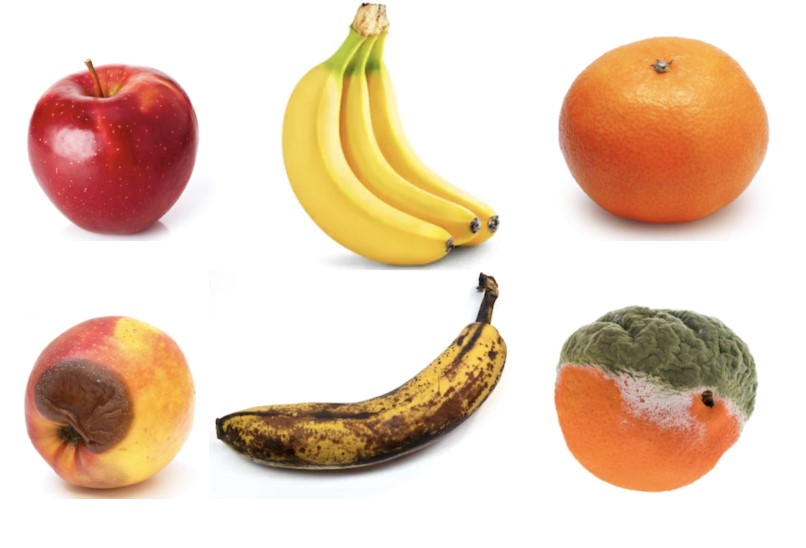

# Carregando Dataset

In [ ]:
import pandas as pd

## Data Augmentation

Para aprimorar os dados que possuimos, será realizada a etapa de Data Augmentation, que basicamente aplica diferentes filtros a imagens que possuimos para que o modelo tenha um escopo maior de aprendizado

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(samplewise_center=True,
    rotation_range=10,     # randomicamente rotaciona a imagem (degrees, 0 para 180)
    zoom_range=0.1,        # .. da zoom na imagem
    width_shift_range=0.1, # .. mexe para esquerda/direita
    height_shift_range=0.1,# .. mexe para o cima/baixo
    horizontal_flip=True,  # .. inverte horizontalmente
    vertical_flip=False,)   # .. inverte verticalmente

datagen_valid = ImageDataGenerator(samplewise_center=True,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,)

## Load

In [ ]:
train = datagen_train.flow_from_directory(
    'data/fruits/train',
    target_size=(224,224),
    color_mode="rgb",
    class_mode="categorical",
)

valid = datagen_valid.flow_from_directory(
    'data/fruits/valid',
    target_size=(224,224),
    color_mode="rgb",
    class_mode="categorical",
)

Found 1182 images belonging to 6 classes.
Found 329 images belonging to 6 classes.


# Imagenet - Modelo base

Iremos utilizar um modelo pré-treinado do ImageNet, que é um modelo famoso para reconhecimento de imagens que o próprio Keras disponibiliza

In [ ]:
from tensorflow import keras

base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Congelando Base Model

Iremos congelar as camadas do modelo de base para que o treinamento das nossas imagens não sobreponha o que ja foi treinado

In [ ]:
# Freeze base model
base_model.trainable = False

# Modelo

## Adicionando Camadas ao modelo

Now it's time to add layers to the pretrained model. [Notebook 05b](05b_presidential_doggy_door.ipynb) can be used as a guide. Pay close attention to the last dense layer and make sure it has the correct number of neurons to classify the different types of fruit.

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

# Camada de Saida
outputs = keras.layers.Dense(6, activation = 'softmax')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs,outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 3078      
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


## Compilando o Modelo

In [ ]:
model.compile(loss = keras.losses.CategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.CategoricalAccuracy()])

## Treinando o Modelo

In [ ]:
model.fit(train,
          validation_data=valid,
          steps_per_epoch=train.samples/train.batch_size,
          validation_steps=valid.samples/valid.batch_size,
          epochs=20)

Epoch 1/20
37/36 [==============================] - 30s 808ms/step - loss: 1.5987 - categorical_accuracy: 0.4332 - val_loss: 1.4743 - val_categorical_accuracy: 0.5471
Epoch 2/20
37/36 [==============================] - 20s 543ms/step - loss: 1.3083 - categorical_accuracy: 0.7555 - val_loss: 1.2013 - val_categorical_accuracy: 0.8541
Epoch 3/20
37/36 [==============================] - 20s 545ms/step - loss: 1.1806 - categorical_accuracy: 0.8748 - val_loss: 1.1693 - val_categorical_accuracy: 0.8845
Epoch 4/20
37/36 [==============================] - 20s 550ms/step - loss: 1.1366 - categorical_accuracy: 0.9129 - val_loss: 1.1387 - val_categorical_accuracy: 0.9119
Epoch 5/20
37/36 [==============================] - 20s 548ms/step - loss: 1.1136 - categorical_accuracy: 0.9416 - val_loss: 1.1077 - val_categorical_accuracy: 0.9422
Epoch 6/20
37/36 [==============================] - 20s 550ms/step - loss: 1.0979 - categorical_accuracy: 0.9569 - val_loss: 1.0992 - val_categorical_accuracy: 0.957

## Evaluate

Considerando uma acuracia de 98%, não será necesário realizar o fine tuning do modelo

In [ ]:
model.evaluate(valid, steps=valid.samples/valid.batch_size)

11/10 [================================] - 4s 352ms/step - loss: 1.0675 - categorical_accuracy: 0.9818


[1.0674843788146973, 0.9817629456520081]

# Testando

In [ ]:
mapeamento = {
    0 : 'Maca',
    1: 'Banana',
    2: 'Laranja',
    3: 'Maca Podre',
    4: 'Banana Podre',
    5: 'Laranja Podre',

}

In [ ]:
def define_classe(image):
    class_prev = np.argmax(model.predict(image), axis=1)[0]
    print('A classe prevista é: ', mapeamento[class_prev])

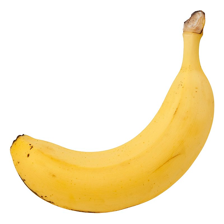

A classe prevista é: Banana


In [ ]:
import numpy as np
from PIL import Image

image = Image.open('BananaPic.png')

input_shape = (224, 224, 3)
image = image.resize((224,224))
image.show()
image = np.array(image)
image = np.expand_dims(image, axis=0)


define_classe(image)

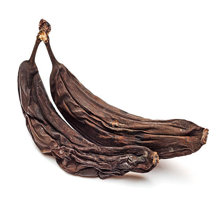

A classe prevista é:  Banana Podre


In [ ]:
image = Image.open('RottenBananaPic.png')

input_shape = (224, 224, 3)
image = image.resize((224,224))
image.show()
image = np.array(image)
image = np.expand_dims(image, axis=0)
define_classe(image)